#MLP Classification

* Data pipline
* Model structure and design
* Model Compilation
* Training/Testing

In [1]:
# import the needed modules

import tensorflow as tf
import numpy as np
import pandas as pd 
import os
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

## Data pipeline

* Read and load the data
* Understand the data
* Remove noise and normalize the data
* Define batches
* Convert to tensors



### MNIST digits classification dataset

This is a dataset of 60,000 28x28 grayscale images of the 10 digits, along with a test set of 10,000 images. More info can be found at the [MNIST homepage](http://yann.lecun.com/exdb/mnist/).

In [2]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
assert x_train.shape == (60000, 28, 28)
assert x_test.shape == (10000, 28, 28)
assert y_train.shape == (60000,)
assert y_test.shape == (10000,)

**Have a look at the data!**



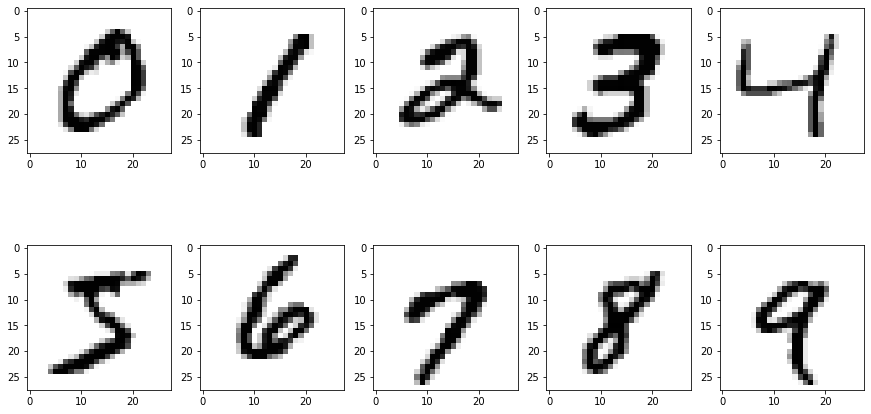

In [3]:
fig, ax = plt.subplots(2,5, figsize=(15, 8))
ax = ax.flatten()
for i in range(10):
    im_idx = np.argwhere(y_train == i)[0]
    plottable_image = np.reshape(x_train[im_idx], (28, 28))
    ax[i].imshow(plottable_image, cmap='gray_r')

### Data Preprocessing

Convert labels to one-Hot encoding

In [4]:
# Here we have a class number for each image
print("Class label of first image :", y_train[0])

# Convert to One-Hot Encoding
y_train = tf.keras.utils.to_categorical(y_train, 10) 
y_test = tf.keras.utils.to_categorical(y_test, 10)

print("After converting the output into a vector : ",y_train[0])

Class label of first image : 5
After converting the output into a vector :  [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]


Inspect the image pixel value

In [5]:
x_train[0].min(), x_train[0].max()

(0, 255)

Normalize the data between `[0,1]`

In [6]:
x_train = x_train/255.0
x_test = x_test/255.0

x_train[0].min(), x_train[0].max()

(0.0, 1.0)

Check the shapes for the data!

In [7]:
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((60000, 28, 28), (10000, 28, 28), (60000, 10), (10000, 10))

Reshape the images so each image is one vector

In [8]:
x_train = x_train.reshape(-1, 28*28)
x_test = x_test.reshape(-1, 28*28)


x_train.shape, x_test.shape, y_train.shape, y_test.shape

((60000, 784), (10000, 784), (60000, 10), (10000, 10))


### **Building the model**


Building the neural network requires configuring the layers of the model, then compiling the model. First we stack a few layers together using `keras.Sequential`. Next we configure the loss function, optimizer, and metrics to monitor. These are added during the model's compile step:

* Loss function - measures how accurate the model is during training, we want to minimize this with the optimizer.
* Optimizer - how the model is updated based on the data it sees and its loss function.
* Metrics - used to monitor the training and testing steps.



In [10]:
#define the optimizer
adam_opt = tf.keras.optimizers.Adam(learning_rate=0.01,
                                    beta_1=0.9,
                                    beta_2=0.999)
#define the loss
loss_ = tf.keras.losses.CategoricalCrossentropy()

#define the number of units per layer
feature_size = 784
unit_size = 500
n_hidden_layers = 0

def build_mlp_model(feature_size, n_hidden_layers, unit_size, opt_, loss_):
    model = tf.keras.Sequential([
        tf.keras.layers.Dense(unit_size, activation=tf.nn.relu, input_shape=(feature_size,))        
    ])

    for i in range(n_hidden_layers):
      model.add(tf.keras.layers.Dense(unit_size, 
                                      activation=tf.nn.relu,
                                      kernel_initializer=tf.keras.initializers.HeUniform(),
                                      bias_initializer=tf.keras.initializers.Zeros(),
                                      kernel_regularizer=tf.keras.regularizers.L1L2(l1=1e-5, l2=1e-4),
                                      bias_regularizer=tf.keras.regularizers.L2(1e-4),
                                      ))

    model.add(tf.keras.layers.Dense(10))
    
    model.compile(optimizer=opt_, 
                  loss=loss_,
                  metrics=['accuracy'])
    
    return model


mlp = build_mlp_model(feature_size, n_hidden_layers, unit_size, adam_opt, loss_)

mlp.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 500)               392500    
                                                                 
 dense_4 (Dense)             (None, 10)                5010      
                                                                 
Total params: 397,510
Trainable params: 397,510
Non-trainable params: 0
_________________________________________________________________



### **Train the model**


Training the neural network model requires the following steps:

1. Feed the training data to the model—in this example, the train features and train labels arrays.
2. The model learns to associate features and labels.
3. We ask the model to make predictions about a test set—in this example, the test_features array. We verify that the predictions match the labels from the test_labels array.



To start training, call the `model.fit` method—the model is "`fit`" to the training data:



In [11]:
batch_size=128
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=50)
history = mlp.fit(x_train, y_train, 
                    epochs=50, 
                    verbose=1,
                    batch_size=batch_size,
                    validation_data = (x_test, y_test),
                    callbacks=[early_stop])

Epoch 1/50
469/469 [==============================] - 10s 18ms/step - loss: 9.5836 - accuracy: 0.1769 - val_loss: 9.7144 - val_accuracy: 0.1807
Epoch 2/50
469/469 [==============================] - 6s 13ms/step - loss: 9.7232 - accuracy: 0.1740 - val_loss: 9.7144 - val_accuracy: 0.1807
Epoch 3/50
469/469 [==============================] - 7s 16ms/step - loss: 9.7232 - accuracy: 0.1740 - val_loss: 9.7144 - val_accuracy: 0.1807
Epoch 4/50
469/469 [==============================] - 6s 13ms/step - loss: 9.7232 - accuracy: 0.1740 - val_loss: 9.7144 - val_accuracy: 0.1807
Epoch 5/50
469/469 [==============================] - 9s 18ms/step - loss: 9.7232 - accuracy: 0.1740 - val_loss: 9.7144 - val_accuracy: 0.1807
Epoch 6/50
469/469 [==============================] - 6s 13ms/step - loss: 9.7232 - accuracy: 0.1740 - val_loss: 9.7144 - val_accuracy: 0.1807
Epoch 7/50
469/469 [==============================] - 7s 15ms/step - loss: 9.7232 - accuracy: 0.1740 - val_loss: 9.7144 - val_accuracy: 0.180

Let's plot the training and validation error

In [12]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch

hist.head()

,loss,accuracy,val_loss,val_accuracy,epoch
0,9.583633,0.176950,9.714375,0.1807,0
1,9.723242,0.174033,9.714375,0.1807,1
2,9.723240,0.174033,9.714375,0.1807,2
3,9.723239,0.174033,9.714375,0.1807,3
4,9.723239,0.174033,9.714375,0.1807,4


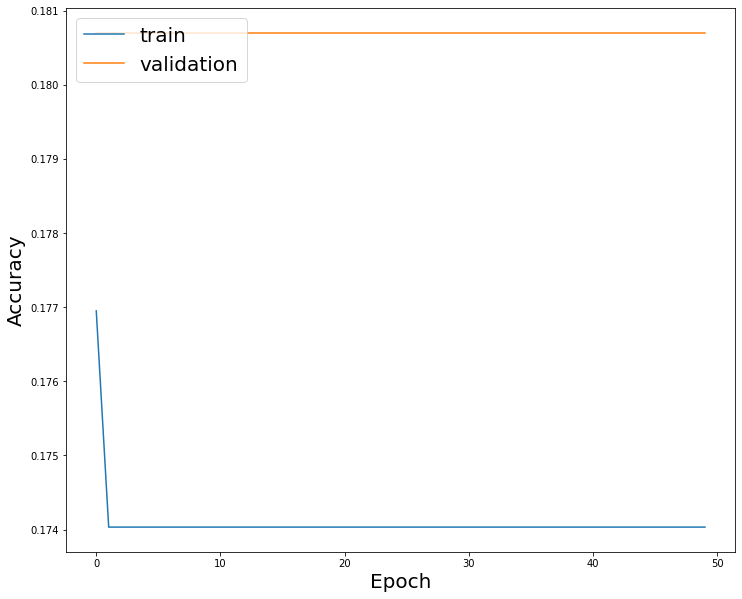

In [13]:

def plot_history(hist_):
    plt.figure(figsize=(12, 10))
    plt.xlabel('Epoch',fontsize=20)
    plt.ylabel('Accuracy',fontsize=20)
    plt.plot(hist['epoch'], hist['accuracy'], label='Train Error')
    plt.plot(hist['epoch'], hist['val_accuracy'], label = 'Val Error')
    plt.legend(["train", "validation"], loc="upper left", prop={'size': 20})


plot_history(hist)

**What would you change?**




---


**End of notebook!**
